## 1. Data 소개
- oxford pet dataset
---
- 37가지 종류의 개와 고양이
- 각 클래스마다 대략 200개씩의 이미지가 있다.
- 모든 이미지들은 head ROI, pixel level, trimap segmentation 정보가 담겨져있다.
---
* trimaps
    + 검정색 이미지가 들어가 있는데, 누끼 딴 이미지가 들어가 있다고 보면 된다.
    + 1 : foreground / 2 : background / 3 : 1과 2가 아닌 정보들
* list.txt
    + Classification에 사용할 수 있는 데이터들이 labeling 되어있다.


## 2. EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# opencv설치
# pip install opencv-python

In [2]:
df = pd.read_csv("data/annotations/list.txt", delimiter=' ', header=None, skiprows=6)
df.head()

,0,1,2,3
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [3]:
df.columns = ['filename', 'id', 'species', 'breed']
df.head() 

,filename,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [4]:
# 고양이와 강아지는 각각 몇마리식인지 찾아보자
df.species.value_counts().sort_index()

1    2371
2    4978
Name: species, dtype: int64

([<matplotlib.axis.XTick at 0x14a502be0>,
 [Text(0, 0, '1'), Text(1, 0, '2')])

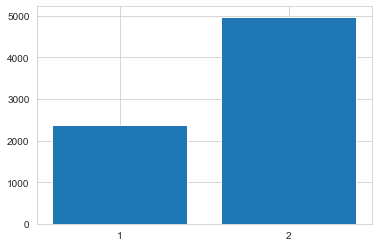

In [5]:
val_cnt = df["species"].value_counts().sort_index()
plt.bar(range(len(val_cnt)), val_cnt.values)
plt.xticks(range(len(val_cnt)), val_cnt.index.values)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

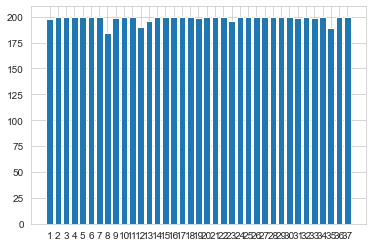

In [6]:
# id별 갯수 확인 
val_cnt = df["id"].value_counts().sort_index()
plt.bar(range(len(val_cnt)), val_cnt.values)
plt.xticks(range(len(val_cnt)), val_cnt.index.values)

plt.tight_layout #지저분한 결과물 지워주기

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

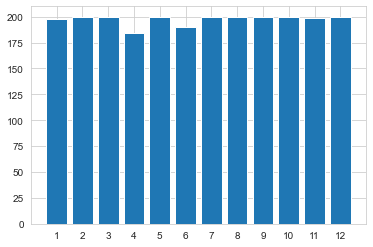

In [7]:
# 고양이에 해당하는 breed 확인
val_cnt = df[df['species'] == 1]["breed"].value_counts().sort_index()
plt.bar(range(len(val_cnt)), val_cnt.values)
plt.xticks(range(len(val_cnt)), val_cnt.index.values)

plt.tight_layout #지저분한 결과물 지워주기

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

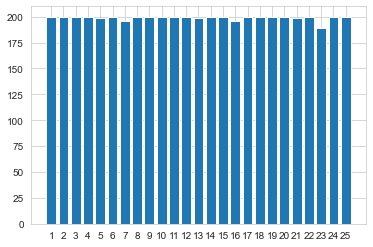

In [8]:
# 강아지에 해당하는 breed 확인
val_cnt = df[df['species'] == 2]["breed"].value_counts().sort_index()
plt.bar(range(len(val_cnt)), val_cnt.values)
plt.xticks(range(len(val_cnt)), val_cnt.index.values)

plt.tight_layout #지저분한 결과물 지워주기

In [9]:
### 결과 : 강아지와 개 수만 차이가 있고, 이 외 나머지 값들의 빈도 수는 균등한 편이다.

In [10]:
#### bounding box 확인
#### glob : 파일 이름을 동시에 불러오게끔 도와주는 라이브러리
import os
from glob import glob

image_dir = "data/images/"
bbox_dir = "data/annotations/xmls/"
seg_dir = "data/annotations/trimaps/"

In [11]:
image_files = glob(image_dir + "*.jpg")
len(image_files)

7390

In [12]:
seg_files = glob(seg_dir + "*.png")
len(seg_files)

7390

In [13]:
bbox_file = glob(bbox_dir + "*.xml")
len(bbox_file)

3686

In [14]:
#### HEAD ROI를 시각화

import cv2
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle

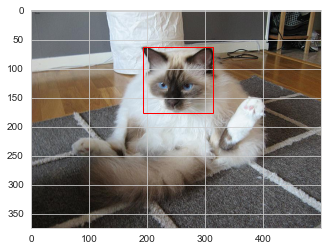

In [31]:
image_path = image_files[6]
bbox_path = image_path.replace(image_dir, bbox_dir).replace("jpg", "xml")

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tree = et.parse(bbox_path)

xmin = float(tree.find("./object/bndbox/xmin").text)
xmax = float(tree.find("./object/bndbox/xmax").text)
ymin = float(tree.find("./object/bndbox/ymin").text)
ymax = float(tree.find("./object/bndbox/ymax").text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.axes().add_patch(rect)
plt.imshow(image)

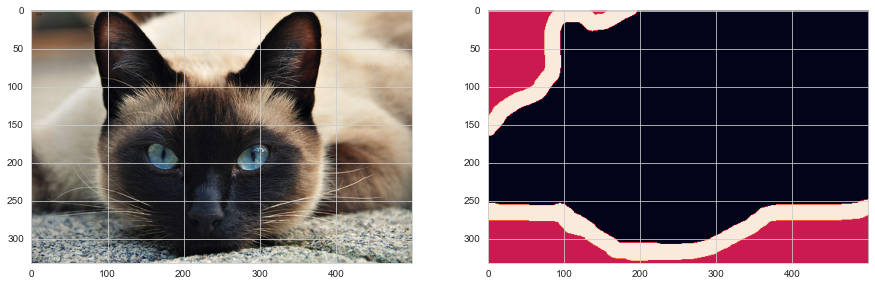

In [33]:
image_path = image_files[5]
seg_path = image_path.replace("jpg", "png")

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

seg_map = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(seg_map)

In [69]:
# 금융권에서 사기꾼 구별
# 0이면 사기꾼, 1이면 정상
# 그런데 1은 100개, 0은 5개 데이터면
# 불균형. 중요한건 사기꾼인데 정상만 잘맞추는 학습될 것
# 이를 해결하기 위해서 연구가 여러 개 이뤄지고 있음
# 그 중 알려진 방법으로 사기꾼 데이터를 부풀리는게 가장 쉽고 일반적


#### EDA에서 이미지 크기 분포도 확인해야한다.
#### 그래야 가장 적합한 이미지 통일 사이즈 정할 수 있다.

### K-Fold를 이용해 데이터 나누기
- KFold
- Stratified KFold : 훨씬 균등함. skf 사용하는걸 추천

#### kfold

In [3]:
from sklearn.model_selection import KFold

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

df["fold"] = -1
for idx, (t,v) in enumerate(kf.split(df), 1):
    print(idx ,t, v, len(v))
    df.loc[v, 'fold'] = idx

1 [   1    2    3 ... 7346 7347 7348] [   0    8   14 ... 7339 7341 7345] 1470
2 [   0    1    2 ... 7346 7347 7348] [  12   15   26 ... 7340 7342 7344] 1470
3 [   0    1    2 ... 7345 7346 7348] [   6    7   18 ... 7333 7343 7347] 1470
4 [   0    3    4 ... 7345 7347 7348] [   1    2   10 ... 7335 7336 7346] 1470
5 [   0    1    2 ... 7345 7346 7347] [   3    4    5 ... 7334 7338 7348] 1469


In [26]:
df

,filename,id,species,breed,fold
0,Abyssinian_100,1,1,1,1
1,Abyssinian_101,1,1,1,4
2,Abyssinian_102,1,1,1,4
3,Abyssinian_103,1,1,1,5
4,Abyssinian_104,1,1,1,5
...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,2
7345,yorkshire_terrier_97,37,2,25,1
7346,yorkshire_terrier_98,37,2,25,4
7347,yorkshire_terrier_99,37,2,25,3


In [35]:
# 여기서 Train / Test 데이터 나눠봅시다.
df_train = df[df['fold'] != 5]
df_test = df[df['fold'] == 5]

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

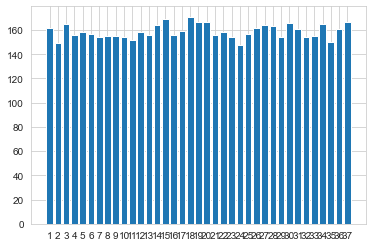

In [42]:
# 데이터 분포 확인하기
# 균형있게 데이터가 나눠졌는지 확인
# 요크셔테리어가 나눠진 데이터에 있어야 나중에 요크셔테리어 보면 판별 가능


value_counts = df[df['fold'] != 1]['id'].value_counts().sort_index()

plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)

plt.tight_layout

#### stratifiedKFold

In [4]:
from sklearn.model_selection import StratifiedKFold

In [44]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df['fold'] = -1
for idx, (t,v) in enumerate(skf.split(df, df['id']), 1):
    print(t, v, len(v))
    df.loc[v, "fold"] = idx

[   0    1    3 ... 7346 7347 7348] [   2    7    8 ... 7326 7337 7345] 1470
[   1    2    3 ... 7346 7347 7348] [   0   12   13 ... 7323 7335 7339] 1470
[   0    2    3 ... 7345 7347 7348] [   1   14   19 ... 7341 7343 7346] 1470
[   0    1    2 ... 7346 7347 7348] [   3    4    5 ... 7334 7338 7342] 1470
[   0    1    2 ... 7343 7345 7346] [   9   21   23 ... 7344 7347 7348] 1469


In [45]:
df

,filename,id,species,breed,fold
0,Abyssinian_100,1,1,1,2
1,Abyssinian_101,1,1,1,3
2,Abyssinian_102,1,1,1,1
3,Abyssinian_103,1,1,1,4
4,Abyssinian_104,1,1,1,4
...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,5
7345,yorkshire_terrier_97,37,2,25,1
7346,yorkshire_terrier_98,37,2,25,3
7347,yorkshire_terrier_99,37,2,25,5


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

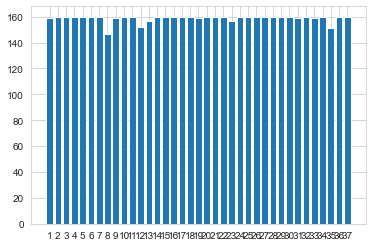

In [49]:
value_counts = df[df['fold'] != 4]['id'].value_counts().sort_index()

plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)

plt.tight_layout

In [50]:
df.to_csv("data/skfolds.csv", index=False)

In [ ]:
df = pd.read_csv("data/skfolds.csv")

## 3. Deep Learning

### Data Loader -> Model Definition -> Training Script
- Sequence()
    * 모델을 클래스로 만들어둔다. 재사용 가능하단 장점이 있다.
    * Data Loader를 위한 클래스
    * Multi Processing에 적합. 성능 좋다
    * https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

In [3]:
import random
import math

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.compat.v2 import keras
import tensorflow.compat.v2 as tf

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, csv_path, fold, image_size, mode, shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == "train":
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == "val":
            self.df = self.df[self.df['fold'] == self.fold]
        #init에선 클래스 내 변수들을 지정해주는 역할을 한다.
        #csv_path = 데이터 받아옴
        #fold = 데이터프레임에 만든 fold 번호 입력 -> 훈련용과 테스트용 나눔. 1~5 입력 가능
        #mode = train과 val 입력 가능. train이면 fold에 입력된 값 외 4개의 데이터가 입력, val이면

        self.on_epoch_end() 

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        # 배치 하나의 갯수를 자체적으로 관리해주는 함수
        # 아래 mini-batchsize 부를 땐, self.batch_size라고 하면 됩니다.
        # def __name__(): 내부관리용. 직접적으로 사용하는 함수가 아니란 의미

    def __getitem__(self, idx):
        start = idx * self.batch_size
        finish = (idx + 1) * self.batch_size
        data = self.df.iloc[start:finish]

        batch_X, batch_y = self.get_data(data)

        return np.array(batch_X), np.array(batch_y)
        # 내가 원하는 미니배치 덩어리를 가져올 수 있게 만들어준다.
    
    def get_data(self, data):
        batch_X = []
        batch_y = []

        for i, j in data.iterrows():
            # i는 index, j는 실제 데이터
            # iterrow()는 행으로 데이터를 하나씩 읽어오는 것을 의미한다
            file_name = j["filename"]

            image = cv2.imread(f"data/images/{file_name}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255. # 이미지 색상 스케일링 통해 성능 향상

            label = int(j['species']) - 1
            batch_X.append(image)
            batch_y.append(label)

        return batch_X, batch_y
        # 오버라이딩 아닌 커스텀 함수
        # 이걸 만든 이유는 우리가 분석해야할 데이터가 이미지이기 때문
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        # 에포크가 한번 끝날 때마다 데이터를 다시 섞어주는 것

In [7]:
csv_path = "data/skfolds.csv"

train_generator = DataGenerator(batch_size=9, csv_path=csv_path, image_size=256, fold=5, mode="train", shuffle=True)
train_generator.df

,filename,id,species,breed,fold
0,newfoundland_74,23,2,16,3
1,Maine_Coon_231,21,1,7,4
2,leonberger_149,20,2,14,3
3,wheaten_terrier_100,36,2,24,3
4,British_Shorthair_101,10,1,5,2
...,...,...,...,...,...
5875,english_setter_194,14,2,8,3
5876,chihuahua_99,11,2,6,1
5877,staffordshire_bull_terrier_37,35,2,23,2
5878,american_bulldog_150,2,2,1,4


In [8]:
len(train_generator)
# return math.ceil(len(self.df) / self.batch_size) 값이 train_generator로 리턴했다

654

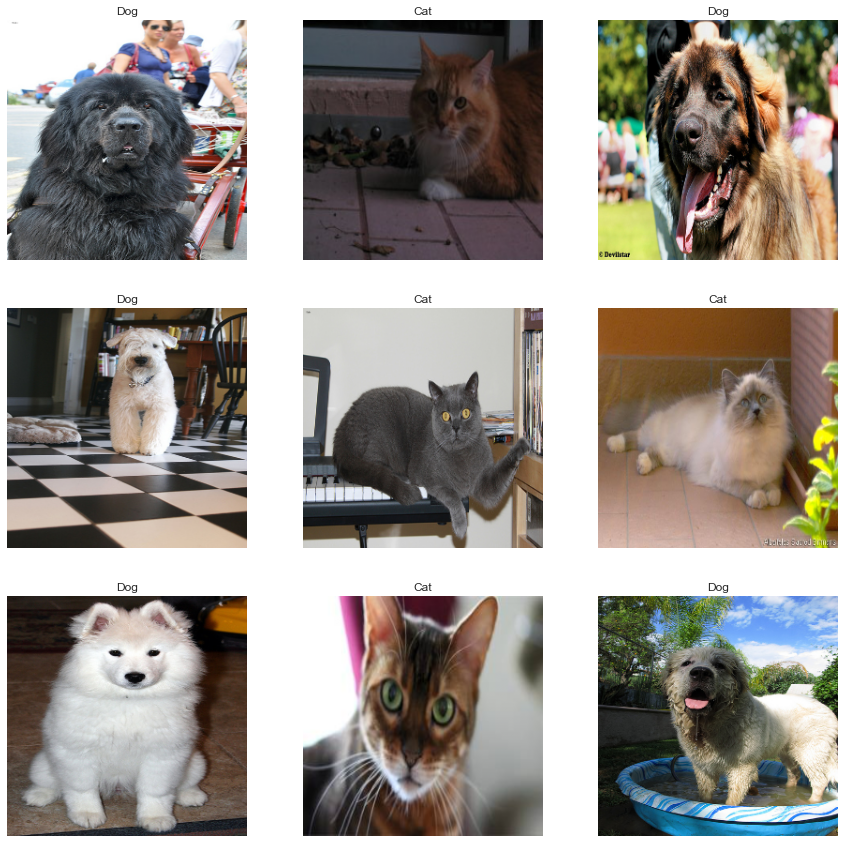

In [9]:
class_name = ['Cat', "Dog"]

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15,15))

    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis("off")
    
    break

## 4. Sequential() 이용한 딥러닝 모델 만들기
- 가장 간단하게 모델을 구현하는 방법
- **하나의 input과 하나의 output을 가지는 모델을 구현
- https://www.tensorflow.org/guide/keras/sequential_model

In [7]:
import tensorflow.compat.v2 as tf
from tensorflow.compat.v2 import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os

In [14]:
tf.enable_v2_behavior()

In [8]:
model = keras.Sequential(
        [
            layers.Input((256,256,3)),

            # 1st conv block
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            # stride : 필터가 움직이는 간격
            # BatchNormalization : 배치돌 때마다 정규화하는 명령어
            # Dropout에서 반을 줄였으면 다음 블럭에선 Conv2D의 갯수를 2배 올려주는 것이 일반적으로 성능이 좋다는 경험!
            # Dropout 1/2 -> next Conv2D *2

            # 1st conv block
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )

In [9]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            layers.Input(input_shape),

            # 1st conv block
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            # stride : 필터가 움직이는 간격
            # BatchNormalization : 배치돌 때마다 정규화하는 명령어
            # Dropout에서 반을 줄였으면 다음 블럭에선 Conv2D의 갯수를 2배 올려주는 것이 일반적으로 성능이 좋다는 경험!
            # Dropout 1/2 -> next Conv2D *2

            # 2st conv block
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )

    return model

In [10]:
input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)    

## 5. Model()을 이용한 딥러닝 모델 만들기
- 복잡한 모델을 직접 만들어 사용할 수 있다. 대신 수작업(인수 이어받게끔 직접 입력해줘야 한다)
- 여러 모델, 여러 결과값 적용할 때 활용 가능하다.

In [4]:
def get_functional_model(input_shape):
    input = layers.Input(input_shape)

    # 1st conv block
    x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(input)
    x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    # stride : 필터가 움직이는 간격
    # BatchNormalization : 배치돌 때마다 정규화하는 명령어
    # Dropout에서 반을 줄였으면 다음 블럭에선 Conv2D의 갯수를 2배 올려주는 것이 일반적으로 성능이 좋다는 경험!
    # Dropout 1/2 -> next Conv2D *2

    # 2st conv block
    x = layers.Conv2D(128, 3, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=1, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalMaxPool2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input, output)

    return model

In [12]:
input_shape = (256, 256, 3)
model = get_functional_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0     

## 6. Model Subclassing
- fit(), evaluate(), predict() 오버라이딩

In [13]:
class SimpleCNN(keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv_block1 = keras.Sequential(
        [
            # 1st conv block
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5)
            # stride : 필터가 움직이는 간격
            # BatchNormalization : 배치돌 때마다 정규화하는 명령어
            # Dropout에서 반을 줄였으면 다음 블럭에선 Conv2D의 갯수를 2배 올려주는 것이 일반적으로 성능이 좋다는 경험!
            # Dropout 1/2 -> next Conv2D *2
        ], name="conv_block1")
        
        self.conv_block2 = keras.Sequential(
        [
            # 2st conv block
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3)
        ], name="conv_block2")

        self.classifier = keras.Sequential(
        [
            # Final conv block
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ], name="classifier")
        
    def call(self, input_tensor, training=False):
        x = self.conv_block1(input_tensor)
        x = self.conv_block2(x)
        output = self.classifier(x)

        return output

In [14]:
input_shape = (None, 256, 256, 3)
model = SimpleCNN()
model.build(input_shape)

model.summary()

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block1 (Sequential)    (None, 128, 128, 64)      38976     
                                                                 
 conv_block2 (Sequential)    (None, 64, 64, 128)       221952    
                                                                 
 classifier (Sequential)     (None, 1)                 16641     
                                                                 
Total params: 277,569
Trainable params: 277,185
Non-trainable params: 384
_________________________________________________________________


## 7. Training Scirpt

In [2]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf

from tensorflow.compat.v2 import keras
from tensorflow.compat.v2.keras import layers
from tensorflow.compat.v2.keras import activations

from tensorflow.python.framework.ops import disable_eager_execution
# conda 환경 내 불필요한 캐쉬 제거 :: conda clean -tispy

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, mode, shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == "train":
            self.df = self.df[self.df["fold"] != self.fold]
        elif self.mode == "val":
            self.df = self.df[self.df["fold"] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[start : fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, j in data.iterrows():
            filename = j["filename"]
            
            image = cv2.imread(f"data/images/{filename}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
            
            label = int(j["species"]) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
#### 학습에 사용될 generator와 validation에 사용될 객체 생성

def get_sequential_model(input_shape):
    tf.enable_v2_behavior()
    disable_eager_execution()

    
    model = keras.Sequential(
        [
            layers.Input(input_shape),

            # 1st Conv Block
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2st Conv Block
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )
    
    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.01), #tf.keras.optimizers.Adam(0.001) // "adam"
    loss = "binary_crossentropy", #"binary_crossentropy" / 'sparse_categorical_crossentropy'
    metrics = ["accuracy"]
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                  

In [5]:
csv_path = "data/skfolds.csv"

train_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="train", 
    shuffle=True
)

valid_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="val", 
    shuffle=True
)

In [6]:
ealry_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1 , mode="min", restore_best_weights=False
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=0.001
)
# reduce_on_plateau는 가장 대표적인 하이퍼파라미터인 learning_rate를 자동으로 조절해준다.
# factor는 얼마만큼 러닝레이트를 곱해줄지
# min_lr = 최소값 지정. 이하로 떨어지면 종료

filepath = "{epoch:02d} - {val_loss:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="min"
)
# 자동으로 현재 딥러닝 모델을 저장 -> 나중에 응용프로그램 만들 때 사용
# save_weights_only는 가중치만 저장! 우린 다른 정보도 사용할 것이기 때문에 False

In [7]:
history = model.fit(
                train_generator,
                validation_data = valid_generator,
                epochs=10,
                callbacks = [
                    ealry_stopping,
                    reduce_on_plateau,
                    model_checkpoint
                ],
                verbose=1
            )



Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-01-14 18:18:17.961175: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-14 18:18:17.961507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-14 18:18:17.984816: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-14 18:18:17.985919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 18:18:18.027825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 18:18:18.281403: I tensorflow/core/grappler/o

Epoch 1/10


2022-01-14 18:18:18.733607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 18:18:18.761351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 18:18:18.817073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

## 8. 데이터 증강
+ 데이터 증강 기법
+ 데이터 양을 늘리기 위해 

In [13]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

In [8]:
# pip install albumentations
import albumentations as A

In [9]:
class Albumentations:
    def __init__(self, size, mode = "train"):
        if mode == "train":
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, shift_limit=0.5, scale_limit=0.5, rotate_limit=15),
                A.CoarseDropout(p=0.5, max_holes=8, max_width=int(0.1 * size), max_height=int(0.1 * size)),
                #A.CoarseDropout은 이미지에 구멍을 뚫는 옵션
                A.RandomBrightnessContrast(p=0.2)
            ])

    def __call__(self, **kwargs):
        if self.transform:
            aug = self.transform(**kwargs)
            img = aug["image"]
            return img
    # **kwargs는 가변인자로 변수 갯수 제한없이 받아들이는 것
    # * 하나는 ():튜플, **는 {:}:딕트로 받습니다.

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, mode, shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == "train":
            self.df = self.df[self.df["fold"] != self.fold]
        elif self.mode == "val":
            self.df = self.df[self.df["fold"] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        
        self.transform = Albumentations(image_size, mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[start : fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, j in data.iterrows():
            filename = j["filename"]
            
            image = cv2.imread(f"data/images/{filename}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))

            if self.mode == "train":
                image = image.astype("uint8") #양수값만 사용:uint8은 양수
                image = self.transform(image=image)
            

            image = image.astype("float32")
            image = image / 255.
            
            label = int(j["species"]) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [15]:
csv_path = "data/skfolds.csv"

train_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="train", 
    shuffle=True
)

valid_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="val", 
    shuffle=True
)

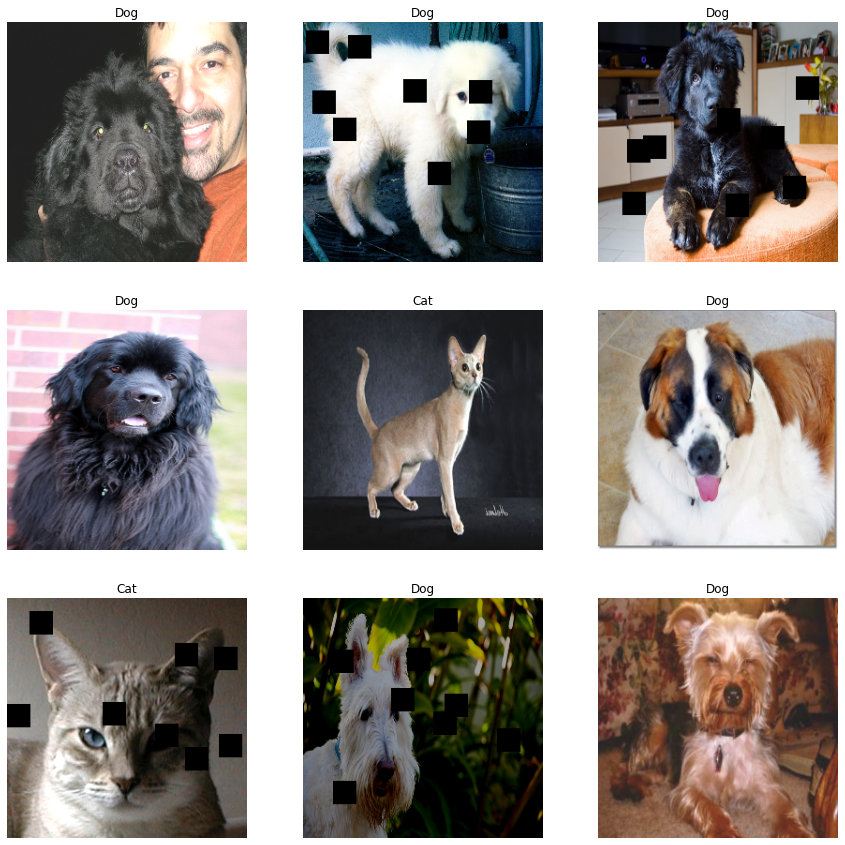

In [16]:
class_name = ['Cat', "Dog"]

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15,15))

    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis("off")
    
    break

In [19]:
def get_sequential_model(input_shape):

    
    model = keras.Sequential(
        [
            layers.Input(input_shape),

            # 1st Conv Block
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(64, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2st Conv Block
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.Conv2D(128, 3, strides=1, activation="relu", padding="same"),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ]
    )
    
    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.01), #tf.keras.optimizers.Adam(0.001) // "adam"
    loss = "binary_crossentropy", #"binary_crossentropy" / 'sparse_categorical_crossentropy'
    metrics = ["accuracy"]
)

model.summary()

2022-01-17 12:02:51.519099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-17 12:02:51.519604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                              

In [20]:
ealry_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1 , mode="min", restore_best_weights=False
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=0.001
)
# reduce_on_plateau는 가장 대표적인 하이퍼파라미터인 learning_rate를 자동으로 조절해준다.
# factor는 얼마만큼 러닝레이트를 곱해줄지
# min_lr = 최소값 지정. 이하로 떨어지면 종료

filepath = "{epoch:02d} - {val_loss:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="min"
)

In [21]:
history = model.fit(
                train_generator,
                validation_data = valid_generator,
                epochs=10,
                callbacks = [
                    ealry_stopping,
                    reduce_on_plateau,
                    model_checkpoint
                ],
                verbose=1
            )

2022-01-17 12:03:22.997177: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-01-17 12:03:23.215257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## 9. Transfer Learning

- 좋은 데이터로 훈련 잘 받은 모델을 가져다 쓰는!
- 특정 분야에서 학습된 모델을 유사하거나 혹은 완전히 새로운 곳에서 사용하는 방법
- https://github.com/keras-team/keras-applications

In [44]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

from tensorflow.keras.applications import EfficientNetB0

In [45]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    
    base_model = EfficientNetB0(input_shape=input_shape, weights="imagenet", include_top=False,
                               pooling='avg')
    
    X = base_model(inputs)
    output = layers.Dense(1, activation="sigmoid")(X)
    model = tf.keras.Model(inputs, output)
    
    return model

In [47]:
input_shape = (256, 256, 3)
model = get_model(input_shape)
adam = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

2022-01-17 13:36:52.936115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-17 13:36:55.412237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-17 13:36:55.974049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_12 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [48]:
# pip install albumentations
import albumentations as A

In [49]:
class Albumentations:
    def __init__(self, size, mode = "train"):
        if mode == "train":
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, shift_limit=0.5, scale_limit=0.5, rotate_limit=15),
                A.CoarseDropout(p=0.5, max_holes=8, max_width=int(0.1 * size), max_height=int(0.1 * size)),
                #A.CoarseDropout은 이미지에 구멍을 뚫는 옵션
                A.RandomBrightnessContrast(p=0.2)
            ])

    def __call__(self, **kwargs):
        if self.transform:
            aug = self.transform(**kwargs)
            img = aug["image"]
            return img
    # **kwargs는 가변인자로 변수 갯수 제한없이 받아들이는 것
    # * 하나는 ():튜플, **는 {:}:딕트로 받습니다.

In [50]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, mode, shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == "train":
            self.df = self.df[self.df["fold"] != self.fold]
        elif self.mode == "val":
            self.df = self.df[self.df["fold"] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        
        self.transform = Albumentations(image_size, mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[start : fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, j in data.iterrows():
            filename = j["filename"]
            
            image = cv2.imread(f"data/images/{filename}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))

            if self.mode == "train":
                image = image.astype("uint8") #양수값만 사용:uint8은 양수
                image = self.transform(image=image)
            

            image = image.astype("float32")
            image = image / 255.
            
            label = int(j["species"]) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [51]:
csv_path = "data/skfolds.csv"

train_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="train", 
    shuffle=True
)

valid_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="val", 
    shuffle=True
)

In [52]:
ealry_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1 , mode="min", restore_best_weights=False
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=0.001
)
# reduce_on_plateau는 가장 대표적인 하이퍼파라미터인 learning_rate를 자동으로 조절해준다.
# factor는 얼마만큼 러닝레이트를 곱해줄지
# min_lr = 최소값 지정. 이하로 떨어지면 종료

filepath = "{epoch:02d} - {val_loss:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="min"
)

In [53]:
history = model.fit(
                train_generator,
                validation_data = valid_generator,
                epochs=10,
                callbacks = [
                    ealry_stopping,
                    reduce_on_plateau,
                    model_checkpoint
                ],
                verbose=1
            )

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/Users/hoon/miniforge3/envs/tf25/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/hoon/miniforge3/envs/tf25/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hoon/miniforge3/envs/tf25/lib/python3.9/site-packages/keras/utils/data_utils.py", line 744, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/Users/hoon/miniforge3/envs/tf25/lib/python3.9/site-packages/keras/utils/data_utils.py", line 635, in <lambda>
    self.executor_fn = lambda _: get_pool_class(False)(workers)
  File "/Users/hoon/miniforge3/envs/tf25/lib/python3.9/multiprocessing/dummy/__init__.py", line 124, in Pool
    return ThreadPool(processes, initializer, initargs)
  File "/Users/hoon/miniforge3/envs/tf25/lib/python3.9/multiprocessing/pool.py", line 927, in __init__
    Pool.__init__(self, processes, initializer, initar

Epoch 1/10


KeyboardInterrupt: 

## 9. Tensorflow Hub
- keras application의 전이학습과 비슷

In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

In [4]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
    trainable=True),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.build([None, 256, 256, 3])  # Batch input shape.

adam = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              7200312   
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 7,201,313
Trainable params: 7,140,705
Non-trainable params: 60,608
_________________________________________________________________


/Users/hoon/miniforge3/envs/tf25/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# pip install albumentations
import albumentations as A

In [6]:
class Albumentations:
    def __init__(self, size, mode = "train"):
        if mode == "train":
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, shift_limit=0.5, scale_limit=0.5, rotate_limit=15),
                A.CoarseDropout(p=0.5, max_holes=8, max_width=int(0.1 * size), max_height=int(0.1 * size)),
                #A.CoarseDropout은 이미지에 구멍을 뚫는 옵션
                A.RandomBrightnessContrast(p=0.2)
            ])

    def __call__(self, **kwargs):
        if self.transform:
            aug = self.transform(**kwargs)
            img = aug["image"]
            return img
    # **kwargs는 가변인자로 변수 갯수 제한없이 받아들이는 것
    # * 하나는 ():튜플, **는 {:}:딕트로 받습니다.

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, mode, shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == "train":
            self.df = self.df[self.df["fold"] != self.fold]
        elif self.mode == "val":
            self.df = self.df[self.df["fold"] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        
        self.transform = Albumentations(image_size, mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[start : fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, j in data.iterrows():
            filename = j["filename"]
            
            image = cv2.imread(f"data/images/{filename}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))

            if self.mode == "train":
                image = image.astype("uint8") #양수값만 사용:uint8은 양수
                image = self.transform(image=image)
            

            image = image.astype("float32")
            image = image / 255.
            
            label = int(j["species"]) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [8]:
csv_path = "data/skfolds.csv"

train_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="train", 
    shuffle=True
)

valid_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="val", 
    shuffle=True
)

In [9]:
ealry_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1 , mode="min", restore_best_weights=False
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=0.001
)
# reduce_on_plateau는 가장 대표적인 하이퍼파라미터인 learning_rate를 자동으로 조절해준다.
# factor는 얼마만큼 러닝레이트를 곱해줄지
# min_lr = 최소값 지정. 이하로 떨어지면 종료

filepath = "{epoch:02d} - {val_loss:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="min"
)

In [10]:
history = model.fit(
                train_generator,
                validation_data = valid_generator,
                epochs=1,
                callbacks = [
                    ealry_stopping,
                    reduce_on_plateau,
                    model_checkpoint
                ],
                verbose=1
            )

2022-01-18 10:21:36.660565: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-18 10:21:39.123751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9212 

2022-01-18 10:37:20.465567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.02039, saving model to 01 - 0.02.hdf5
46/46 [==============================] - 953s 21s/step - loss: 0.1797 - accuracy: 0.9212 - val_loss: 0.0204 - val_accuracy: 0.9905 - lr: 1.0000e-04


In [13]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

AttributeError: 'dict' object has no attribute 'history'

## Multiple Classification

In [14]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2",
    trainable=True),
    tf.keras.layers.Dense(37, activation="softmax")
])
model.build([None, 256, 256, 3])  # Batch input shape.

adam = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1000)              7200312   
                                                                 
 dense_2 (Dense)             (None, 37)                37037     
                                                                 
Total params: 7,237,349
Trainable params: 7,176,741
Non-trainable params: 60,608
_________________________________________________________________


/Users/hoon/miniforge3/envs/tf25/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# pip install albumentations
import albumentations as A

In [ ]:
class Albumentations:
    def __init__(self, size, mode = "train"):
        if mode == "train":
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, shift_limit=0.5, scale_limit=0.5, rotate_limit=15),
                A.CoarseDropout(p=0.5, max_holes=8, max_width=int(0.1 * size), max_height=int(0.1 * size)),
                #A.CoarseDropout은 이미지에 구멍을 뚫는 옵션
                A.RandomBrightnessContrast(p=0.2)
            ])

    def __call__(self, **kwargs):
        if self.transform:
            aug = self.transform(**kwargs)
            img = aug["image"]
            return img
    # **kwargs는 가변인자로 변수 갯수 제한없이 받아들이는 것
    # * 하나는 ():튜플, **는 {:}:딕트로 받습니다.

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size, fold, mode, shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == "train":
            self.df = self.df[self.df["fold"] != self.fold]
        elif self.mode == "val":
            self.df = self.df[self.df["fold"] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        
        self.transform = Albumentations(image_size, mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[start : fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, j in data.iterrows():
            filename = j["filename"]
            
            image = cv2.imread(f"data/images/{filename}.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))

            if self.mode == "train":
                image = image.astype("uint8") #양수값만 사용:uint8은 양수
                image = self.transform(image=image)
            

            image = image.astype("float32")
            image = image / 255.
            
            label = int(j["id"]) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [ ]:
csv_path = "data/skfolds.csv"

train_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="train", 
    shuffle=True
)

valid_generator = DataGenerator(
    batch_size=128, 
    csv_path = csv_path, 
    image_size=256, 
    fold=1, 
    mode="val", 
    shuffle=True
)

In [ ]:
ealry_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, verbose=1 , mode="min", restore_best_weights=False
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="min", min_lr=0.001
)
# reduce_on_plateau는 가장 대표적인 하이퍼파라미터인 learning_rate를 자동으로 조절해준다.
# factor는 얼마만큼 러닝레이트를 곱해줄지
# min_lr = 최소값 지정. 이하로 떨어지면 종료

filepath = "{epoch:02d} - {val_loss:.2f}.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="min"
)

In [ ]:
history = model.fit(
                train_generator,
                validation_data = valid_generator,
                epochs=1,
                callbacks = [
                    ealry_stopping,
                    reduce_on_plateau,
                    model_checkpoint
                ],
                verbose=1
            )

2022-01-18 10:21:36.660565: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-18 10:21:39.123751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9212 

2022-01-18 10:37:20.465567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.02039, saving model to 01 - 0.02.hdf5
46/46 [==============================] - 953s 21s/step - loss: 0.1797 - accuracy: 0.9212 - val_loss: 0.0204 - val_accuracy: 0.9905 - lr: 1.0000e-04


In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

AttributeError: 'dict' object has no attribute 'history'